<a href="https://colab.research.google.com/github/IsraelAlvarado/tareas-bigdata/blob/main/1_2_tarea_clusters_con_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importación de librerías y creación de la sesión Spark
Se cargan las librerías necesarias de PySpark, pandas, numpy y seaborn, y se crea la sesión de Spark que permitirá ejecutar los algoritmos de clustering en paralelo.**

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [40]:
spark = SparkSession.builder.appName("Clustering2D").getOrCreate()

**Carga y exploración del dataset
Se lee un archivo CSV con tres columnas (x, y, color) desde el sistema de archivos y se muestra su esquema junto con las primeras filas para verificar los datos.**

**2D Clustering Data	Dataset en dos dimensiones para practicar algoritmos de clustering y visualización.**

In [41]:
hdfs_path = "/content/data.csv"
df = spark.read.option("header", "true").option("inferSchema", "true").csv(hdfs_path)

**Preparación y normalización de los datos
Se seleccionan las columnas numéricas, se eliminan valores nulos o duplicados, se ensamblan en un vector de características y luego se escalan para que todas tengan el mismo peso.**

In [42]:
df.printSchema()
df.show(5)

root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- color: integer (nullable = true)

+------------------+------------------+-----+
|                 x|                 y|color|
+------------------+------------------+-----+
| 516.0127058374305|393.01451385201693|    0|
| 436.2117622061974| 408.6565848615271|    0|
| 512.0526012254161|372.02201357478293|    0|
|489.14046445291086|  401.807159361874|    0|
| 446.2079858903369|338.51668220520173|    0|
+------------------+------------------+-----+
only showing top 5 rows



In [43]:
data = df.select(col("x").cast("double"), col("y").cast("double")).na.drop().dropDuplicates()

In [44]:
assembler = VectorAssembler(inputCols=["x","y"], outputCol="features")
data_v = assembler.transform(data)

In [45]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(data_v)
data_s = scaler_model.transform(data_v).select("x","y","scaledFeatures")

In [46]:
ks = [2,3,4,5,6]

results = {}

**Configuración de los modelos y función de evaluación
Se define una función para entrenar y evaluar cada modelo de clustering (KMeans, GaussianMixture y BisectingKMeans) con distintos valores de k, calculando el índice de silueta para comparar su desempeño.**

In [47]:
from pyspark.sql import functions as F

def fit_and_score(model, feature_col="scaledFeatures"):
    mdl = model.fit(data_s)
    pred = mdl.transform(data_s)

    # verificar si hay más de un cluster distinto
    num_clusters = pred.select("prediction").distinct().count()

    if num_clusters > 1:
        evaluator = ClusteringEvaluator(
            featuresCol=feature_col,
            predictionCol="prediction",
            metricName="silhouette",
            distanceMeasure="squaredEuclidean"
        )
        sil = evaluator.evaluate(pred)
    else:
        sil = float('-inf')  # Return negative infinity for single cluster or no valid score

    return mdl, pred, sil

**Entrenamiento de modelos y evaluación de resultados
Se ejecutan los tres algoritmos con diferentes números de clústeres y se imprimen los resultados del índice de silueta para determinar cuál configuración es la más adecuada.**

In [48]:
for k in ks:
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    mdl, pred, sil = fit_and_score(kmeans)
    centers = mdl.clusterCenters()
    results[f"kmeans_{k}"] = {"model": mdl, "pred": pred, "silhouette": sil, "centers": centers}

In [49]:
for k in ks:
    gmm = GaussianMixture(featuresCol="scaledFeatures", k=k, seed=42)
    mdl, pred, sil = fit_and_score(gmm)
    results[f"gmm_{k}"] = {"model": mdl, "pred": pred, "silhouette": sil}

In [50]:
for k in ks:
    bkm = BisectingKMeans(featuresCol="scaledFeatures", k=k, seed=42)
    mdl, pred, sil = fit_and_score(bkm)
    results[f"bkm_{k}"] = {"model": mdl, "pred": pred, "silhouette": sil, "centers": mdl.clusterCenters()}


**Selección del mejor modelo
Se identifica el mejor modelo de cada tipo (KMeans, GMM, BisectingKMeans) según su valor de silueta, guardando los resultados en un diccionario para uso posterior.**

In [60]:
best = {}
for alg in ["kmeans", "gmm", "bkm"]:
    candidates = {
        k: v for k, v in results.items()
        if k.startswith(alg) and v["silhouette"] not in [None, float('-inf')]
    }

    if candidates:
        best_k = max(candidates.items(), key=lambda x: x[1]["silhouette"])
        best[alg] = best_k
        print(f"Mejor {alg}: {best_k[0]} con silhouette {best_k[1]['silhouette']:.4f}")
    else:
        fallback = min(
            (v for k, v in results.items() if k.startswith(alg)),
            key=lambda x: x["silhouette"]
        )
        best[alg] = ("sin_valido", fallback)
        print(f"Mejor {alg}: sin silhouette válida (modelo asignado por fallback)")


Mejor kmeans: kmeans_3 con silhouette 0.8131
Mejor gmm: gmm_3 con silhouette 0.8131
Mejor bkm: sin silhouette válida (modelo asignado por fallback)


In [52]:
best_kmeans_name, best_kmeans_info = best["kmeans"]
pred_df = best_kmeans_info["pred"].select("x","y","prediction").toPandas()

**Visualización de los clústeres
Se generan gráficos de dispersión para observar los grupos formados por KMeans y GMM, usando colores y tamaños de puntos para representar clústeres y niveles de confianza.**

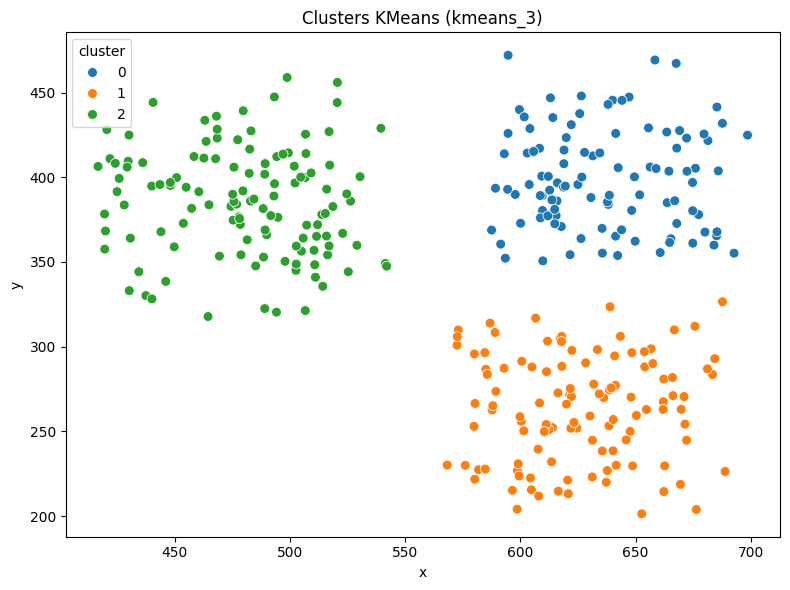

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pred_df, x="x", y="y", hue="prediction", palette="tab10", s=50)
plt.title(f"Clusters KMeans ({best_kmeans_name})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()

In [54]:
best_gmm_name, best_gmm_info = best["gmm"]
gmm_pred_pd = best_gmm_info["pred"].select("x","y","probability").toPandas()

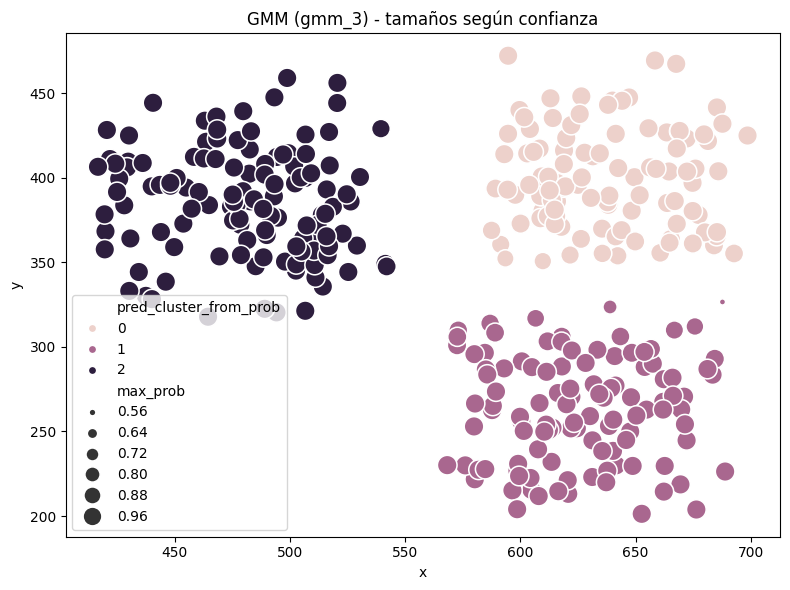

In [55]:
gmm_pred_pd["max_prob"] = gmm_pred_pd["probability"].apply(lambda v: float(np.max(v)))
gmm_pred_pd["pred_cluster_from_prob"] = gmm_pred_pd["probability"].apply(lambda v: int(np.argmax(v)))
plt.figure(figsize=(8,6))
sns.scatterplot(data=gmm_pred_pd, x="x", y="y", hue="pred_cluster_from_prob", size="max_prob", sizes=(20,200))
plt.title(f"GMM ({best_gmm_name}) - tamaños según confianza")
plt.tight_layout()
plt.show()

**Análisis de estadísticas por clúster
Se calculan las medias y el número de elementos por clúster, mostrando un resumen de cómo se distribuyen los puntos.**

In [56]:
cluster_stats = pred_df.groupby("prediction").agg({"x":"mean","y":"mean","prediction":"count"}).rename(columns={"prediction":"count"})
print(cluster_stats)

                     x           y  count
prediction                               
0           637.266078  399.331838    103
1           626.033545  263.373386    112
2           480.604300  385.445064    121


In [57]:
out_path = "/content/clustering_results/kmeans_best"
best_kmeans_info["pred"].select("x","y","prediction").write.mode("overwrite").option("header","true").csv(out_path)

In [58]:
model_out = "/content/clustering_models/kmeans_best"
best_kmeans_info["model"].write().overwrite().save(model_out)